In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


In [ ]:
data_df = pd.read_csv("churn.csv")

data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Get overview of the data
def dataoveriew(df, message):
    print(f'{message}:\n')
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())
    
dataoveriew(data_df, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  7043

Number of features: 21

Data Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values: 0

Unique values:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


The data fall under two categories:
- 17 Categorical features:
    - CustomerID: Customer ID unique for each customer
    - gender: Whether the customer is a male or a female
    - SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
    - Partner: Whether the customer has a partner or not (Yes, No)
    - Dependent: Whether the customer has dependents or not (Yes, No)
    - PhoneService: Whether the customer has a phone service or not (Yes, No)
    - MultipeLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
    - InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
    - OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
    - OnlineBackup: Whether the customer has an online backup or not (Yes, No, No internet service)
    - DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
    - TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
    - StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
    - StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
    - Contract: The contract term of the customer (Month-to-month, One year, Two years)
    - PaperlessBilling: The contract term of the customer (Month-to-month, One year, Two years)
    - PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
    
***
    
- 3 Numerical features:

    - Tenure: Number of months the customer has stayed with the company 
    - MonthlyCharges: The amount charged to the customer monthly
    - TotalCharges: The total amount charged to the customer
      
***

- Prediction feature:
    - Churn: Whether the customer churned or not (Yes or No)
    
    
These features can also be sub-divided into:

- Demographic customer information

    - gender , SeniorCitizen , Partner , Dependents

- Services that each customer has signed up for

    - PhoneService , MultipleLines , InternetService , OnlineSecurity , OnlineBackup , DeviceProtection , TechSupport , StreamingTV , StreamingMovies, 
    
- Customer account information

    - tenure , Contract , PaperlessBilling , PaymentMethod , MonthlyCharges , TotalCharges

In [4]:
target_instance = data_df["Churn"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
fig = px.pie(target_instance, values='Churn', names='Category', color_discrete_sequence=px.colors.qualitative.D3,
             title='Distribution of Churn')
fig.show()

We are trying to predict users that left the company in the previous month. It is a binary classification problem with an unbalance target.
- Churn: No - 73.5%
- Churn: Yes - 26.5%

In [5]:
#Defining bar chart function
def bar(feature, df=data_df ):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Churn']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str


    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)
    
    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Churn', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=px.colors.qualitative.D3)
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )
     
    return fig.show()

In [6]:
#Gender feature plot
bar('gender')
#SeniorCitizen feature plot 
data_df.loc[data_df.SeniorCitizen==0,'SeniorCitizen'] = "No"   #convert 0 to No in all data instances
data_df.loc[data_df.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #convert 1 to Yes in all data instances
bar('SeniorCitizen')
#Partner feature plot
bar('Partner')
#Dependents feature plot
bar('Dependents')

***
**Demographic analysis Insight**: 
Gender and partner are even distributed with approximate percentage values. The difference in churn is slightly higher in females but the difference is negligible. There is a higher proportion of churn amongst younger customers (where SeniorCitizen is No), customers with no partners and customers with no dependents. These analysis on demographic section of data highlights on-senior citizens with no partners and dependents describe a particular segment of customers that are likely to churn.
***

In [7]:
bar('PhoneService')
bar('MultipleLines')
bar('InternetService')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('TechSupport')
bar('StreamingTV')
bar('StreamingMovies')

***
**Services that each customer has signed up for Insight**:
These category of features shows significant variations across their values. If a customer does not have a phone service, he/she cannot have multiple lines. About 90.3% of the customers have phone services and have the higher rate to churn. Customers who have Fibre optic as internet service are more likely to churn, this can happen due to high prices, competition, customer service, and many other reasons. Fiber optic service is much more expensive than DSL which may be one of the reasons why customers churn. Customers with  OnlineSecurity ,OnlineBackup ,DeviceProtection and TechSupport  are more unlikely to churn. Streaming service is not predictive for churn as it evenly distributed to yes and no options.
***

In [8]:
bar('Contract')
bar('PaperlessBilling')
bar('PaymentMethod')

**Payment**:
***
The shorter the contract the higher churn rate as those with longer plans face additional barriers when cancelling prematurely. This clearly explains the motivation for companies to have long-term relationship with their customers. Churn Rate is higher for the customers who opted for paperless billing, About 59.2% of the customers make paperless billing. Customers who pay with electronic check are more likely to churn and this kind of payment is more common than other payment types.
***

### Explore Numeric features

In [9]:
data_df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
try:
    data_df['TotalCharges'] = data_df['TotalCharges'].astype(float)
except ValueError as ve:
    print (ve)

could not convert string to float: ' '


In [11]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'],errors='coerce')
#Fill the missing values with with the median value
data_df['TotalCharges'] = data_df['TotalCharges'].fillna(data_df['TotalCharges'].median())

In [12]:
# Defining the histogram plotting function
def hist(feature):
    group_df = data_df.groupby([feature, 'Churn']).size().reset_index()
    group_df = group_df.rename(columns={0: 'Count'})
    fig = px.histogram(group_df, x=feature, y='Count', color='Churn', marginal='box', title=f'Churn rate frequency to {feature} distribution', color_discrete_sequence=px.colors.qualitative.D3)
    fig.show()

In [13]:
hist('tenure')
hist('MonthlyCharges')
hist('TotalCharges')

***
**Customer account information**: The tenure histogram is rightly skewed and shows that majority of customers has been with the telecom company for just the first few months (0-9 months) and the highest rate of churn is also in that first few months (0-9months). 75% of customers who end up leaving Telcom company  do so within their first 30 months. The monthly charge histogram shows that clients with higher monthly charges have a higher churn rate (This suggests that discounts and promotions can be an enticing reason for customers to stay). The total charge trend is quite depict due to variation in frequency.
Lets bin the numeric features into 3 sections based on quantiles (low, medium and high to get more information from it).
***

In [14]:
#Create an empty dataframe
bin_df = pd.DataFrame()

#Update the binning dataframe
bin_df['tenure_bins'] =  pd.qcut(data_df['tenure'], q=3, labels= ['low', 'medium', 'high'])
bin_df['MonthlyCharges_bins'] =  pd.qcut(data_df['MonthlyCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['TotalCharges_bins'] =  pd.qcut(data_df['TotalCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['Churn'] = data_df['Churn']

#Plot the bar chart of the binned variables
bar('tenure_bins', bin_df)
bar('MonthlyCharges_bins', bin_df)
bar('TotalCharges_bins', bin_df)

***
Based on binning, the low tenure and high monthly charge bins have higher churn rates as supported with the previous analysis. While the low Total charge bin has a higher churn rate. 
***

### Data preprocessing

In [15]:
data_df["Churn"].replace("Yes",1,inplace=True)
data_df["Churn"].replace("No",0,inplace=True)
data_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [16]:
# The customerID column isnt useful as the feature us used for identification of customers. 
data_df.drop(["customerID"],axis=1,inplace = True)

In [17]:
df_dummies = pd.get_dummies(data_df, drop_first=True)   # converting categorical variables into dummy variables

In [18]:
data_df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
# Checking the correlation between features
corr = data_df.corr()

fig = px.imshow(corr,width=1000, height=1000)
fig.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20068\1468704448.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Correlation is a statistical term is a measure on linear relationship with two variables. Features with high correlation are more linearly dependent and have almost the same effect on the dependent variable. So when two features have a high correlation, we can drop one of the two features.

### Feature Scaling

In [20]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

# Training , Testing & tuning models

In [21]:
# Create Train & Test Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Logistic Regression

In [22]:
log_model = LogisticRegression()
result = log_model.fit(X_train, y_train)

In [23]:
prediction_test = log_model.predict(X_test)
# Print the prediction accuracy
print(metrics.accuracy_score(y_test, prediction_test))

0.8050165641268339


### Hyperparameter Tuning of LR

In [24]:
# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],               # Penalty norm
    'solver': ['liblinear'],               # Solver for optimization problem
    'max_iter': [100, 200, 300]            # Maximum number of iterations
}

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [25]:
# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

Best Parameters: {'C': 100, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-validation Score: 0.8020283975659229
Test Accuracy: 0.8035967818267865

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1546
           1       0.67      0.53      0.59       567

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



### Random Forest

In [26]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.780407004259347


## Hyperparameter Tuning of RF

In [27]:

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [28]:
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

Best Parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 200}
Best Cross-validation Score: 0.8042243521476747
Test Accuracy: 0.7984386089425124

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1026
           1       0.70      0.46      0.55       383

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409



## Support Vecor Machine (SVM)

In [ ]:
model_svm = SVC()
model_svm.fit(X_train,y_train)
preds_svm = model_svm.predict(X_test)
metrics.accuracy_score(y_test, preds_svm)

0.7977288857345636

## Hyperparameter Tuning of SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(estimator = model_svm, param_grid = param_grid, cv=3)

In [ ]:
grid.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

# Decision Tree

In [ ]:
# Make an instance of the Model
dt = DecisionTreeClassifier()

# Train the model on the data
dt.fit(X_train, y_train)

dt_predict=dt.predict(X_test)
metrics.accuracy_score(y_test, dt_predict)

# Hyperparameter Tuning of DT

In [ ]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [ ]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

# Boosting Algorithm

## AdaBoost Algorithm

In [ ]:
ada_model = AdaBoostClassifier()
# n_estimators = 50 (default value)
# base_estimator = DecisionTreeClassifier (default value)
ada_model.fit(X_train,y_train)
preds = ada_model.predict(X_test)
metrics.accuracy_score(y_test, preds)

In [ ]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier())

parameters = {'estimator__max_depth':[i for i in range(2,11,2)],
              'estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

clf = GridSearchCV(ada, parameters,verbose=3,scoring="accuracy",n_jobs=-1)
clf.fit(X_train,y_train)

In [ ]:
# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

## XG Boost

In [ ]:
# XGBoost

xg_model = XGBClassifier()
xg_model.fit(X_train, y_train)
preds = xg_model.predict(X_test)
metrics.accuracy_score(y_test, preds)

In [ ]:
xgb = XGBClassifier()

parameters = {'max_depth':[i for i in range(2,11,2)],
              'min_child_weight':[i for i in range(1,6,2)],
              'reg_alpha':[0,0.005,0.01],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]
              }

model = GridSearchCV(xgb, parameters,verbose=3,cv=3,scoring="accuracy",n_jobs=-1)
model.fit(X_train,y_train)

# Optimal parameters found during grid search
Optimal_params = grid_search.best_params_
print("Best Parameters:", Optimal_params)

# Optimal cross-validation score
Optimal_score = grid_search.best_score_
print("Best Cross-validation Score:", Optimal_score)

# Train model with Optimal parameters on full training set
Optimal_model = grid_search.best_estimator_
Optimal_model.fit(X_train, y_train)

# Evaluate model performance on test set
test_accuracy = Optimal_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


prediction_test = Optimal_model.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test, prediction_test))

In [ ]:
importances = model.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')
plt.show()

# SHAP

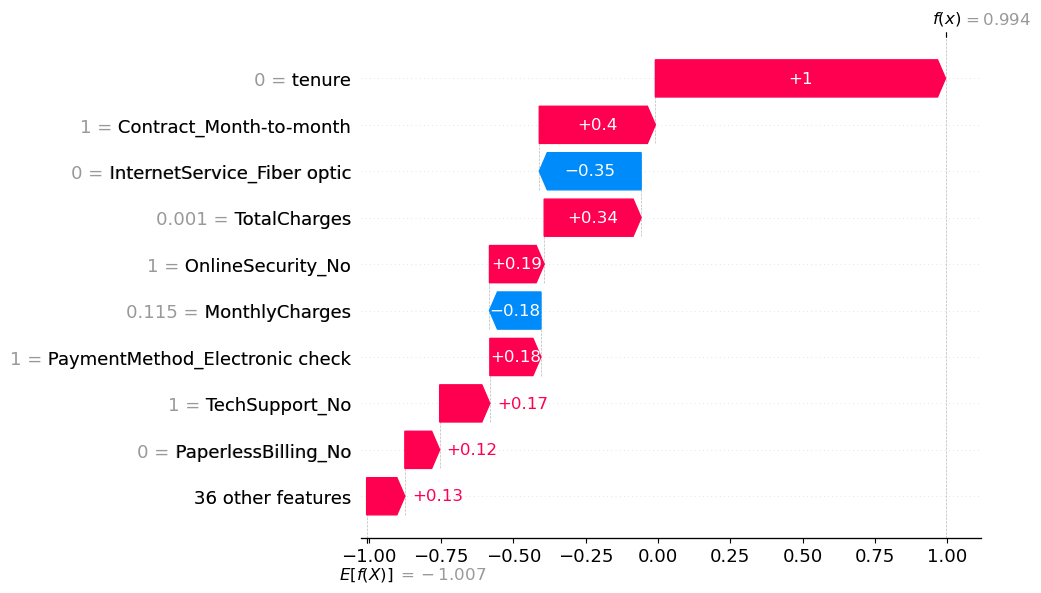

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.initjs()

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])

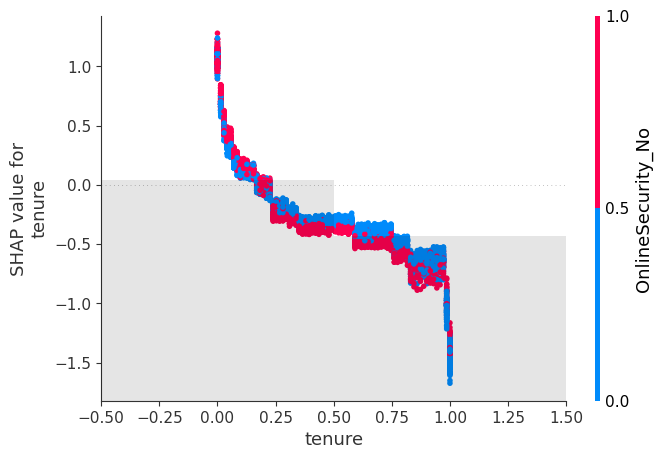

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:, "tenure"], color=shap_values)
shap.plots.scatter(shap_values[:, X.columns.get_loc("tenure")], color=shap_values)

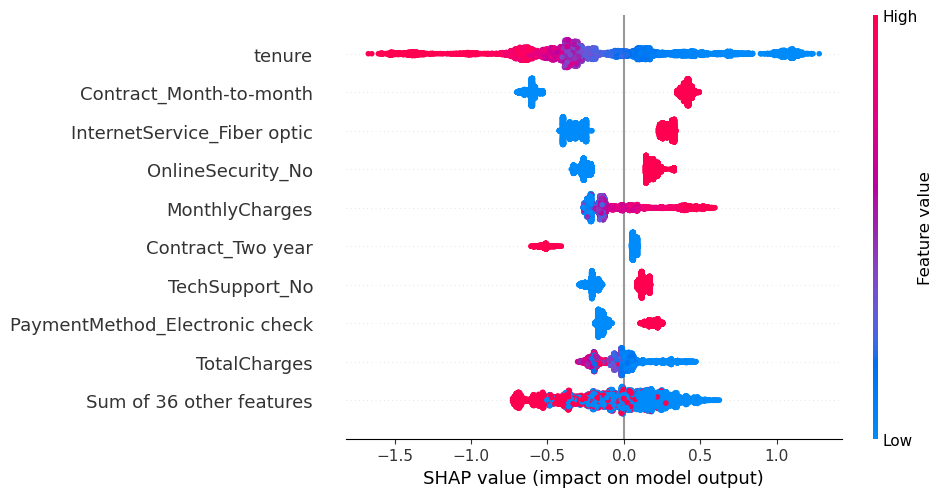

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

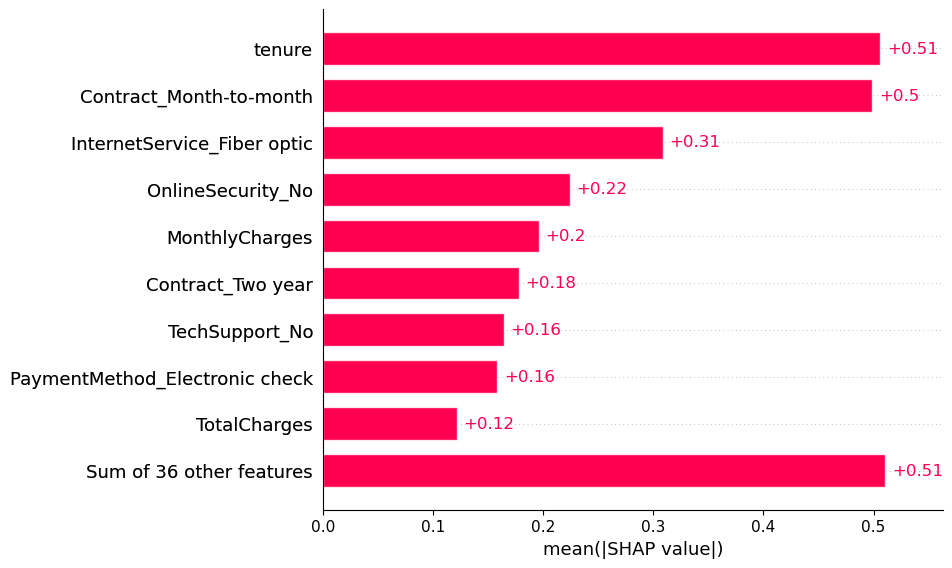

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
#Saving best model 
import joblib
#Sava the model to disk
filename = 'model.sav'
joblib.dump(model, filename)

In [ ]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

# these have negative relation with churn